In [ ]:
import numpy as np
import pandas as pd 
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
import matplotlib.pyplot as plt

from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.utils import from_scipy_sparse_matrix, train_test_split_edges
from scipy.sparse import coo_matrix
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import add_self_loops
import csv
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, average_precision_score


import numpy as np

In [3]:
#pip install torch torchvision torchaudio
#pip install torch-geometric

In [4]:
ppi_df = pd.read_csv('9606.protein.links.v12.0.txt', delimiter= ' ')
rna_pca_df = pd.read_csv('Data/PPI_RNA_seq_10PCs.csv')
pe_pca_df = pd.read_csv('Data/PPI_protein_expression_10PCs.csv')
#ppi_df = pd.read_csv('filtered_PPI.csv')


In [5]:
ppi_df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000356607,173
1,9606.ENSP00000000233,9606.ENSP00000427567,154
2,9606.ENSP00000000233,9606.ENSP00000253413,151
3,9606.ENSP00000000233,9606.ENSP00000493357,471
4,9606.ENSP00000000233,9606.ENSP00000324127,201
...,...,...,...
13715399,9606.ENSP00000501317,9606.ENSP00000475489,195
13715400,9606.ENSP00000501317,9606.ENSP00000370447,158
13715401,9606.ENSP00000501317,9606.ENSP00000312272,226
13715402,9606.ENSP00000501317,9606.ENSP00000402092,169


In [6]:
rna_pca_df

,Protein,0,1,2,3,4,5,6,7,8,9
0,ENSP00000362111,-0.185353,-0.004533,-0.026467,0.023489,0.006372,0.010350,-0.017638,-0.018963,-0.090908,-0.125234
1,ENSP00000362122,-0.399261,-0.149002,-0.018040,-0.014601,0.003538,-0.009605,-0.007200,0.007645,-0.001761,0.003506
2,ENSP00000360638,-0.112412,0.007942,-0.021386,-0.001733,-0.014926,-0.003674,-0.005983,-0.013011,-0.020831,-0.011808
3,ENSP00000356746,-0.354238,-0.122491,-0.019377,-0.014322,0.005443,-0.006755,-0.006351,-0.003301,-0.002537,0.006392
4,ENSP00000286031,-0.394177,-0.147828,-0.018580,-0.015931,0.009358,-0.011189,-0.006518,0.001496,-0.007399,0.001637
...,...,...,...,...,...,...,...,...,...,...,...
19076,ENSP00000479586,-0.398100,-0.144587,-0.019146,-0.017504,0.014688,-0.014939,-0.003438,0.006843,-0.000927,0.012801
19077,ENSP00000492798,-0.409664,-0.154259,-0.017906,-0.015920,0.010782,-0.011493,-0.005786,0.008363,-0.000526,0.008326
19078,ENSP00000491046,-0.384420,-0.151079,-0.018764,-0.017182,0.009419,-0.011501,-0.008080,-0.012846,-0.020369,-0.009728
19079,ENSP00000491768,-0.412952,-0.153543,-0.017814,-0.016148,0.010864,-0.011281,-0.005109,0.007937,0.000992,0.010568


In [7]:
pe_pca_df

,Protein,0,1,2,3,4,5,6,7,8,9
0,ENSP00000475939,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
1,ENSP00000448165,-2.626324,1.219481,1.920547,-0.270693,-0.725231,0.880273,-0.456950,0.483047,0.868281,-1.455956
2,ENSP00000381148,0.717924,-2.768436,-0.418082,0.960015,0.635807,-0.778343,-0.028056,0.380815,-0.014020,-0.236685
3,ENSP00000326598,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
4,ENSP00000316605,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
...,...,...,...,...,...,...,...,...,...,...,...
10427,ENSP00000356231,2.504925,0.838916,1.854173,1.143358,-1.016118,-0.651189,0.523027,0.668288,-1.892422,0.579353
10428,ENSP00000376623,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
10429,ENSP00000496731,6.653803,0.376571,-0.548003,1.129220,-0.956416,0.208612,-0.717141,-0.812586,0.522268,0.654601
10430,ENSP00000457205,-4.150368,2.336989,-1.682337,2.139072,-1.398343,-0.840981,-0.036713,0.173603,-0.350784,-0.934075


In [8]:
def find_common_prefix(strings):
    if not strings:
        return ""
    prefix = strings[0]
    for string in strings[1:]:
        while not string.startswith(prefix):
            prefix = prefix[:-1]
            if not prefix:
                return ""
    return prefix


protein1_prefix = find_common_prefix(ppi_df['protein1'].tolist())
protein2_prefix = find_common_prefix(ppi_df['protein2'].tolist())

print("Common prefix in 'protein1':", protein1_prefix)
print("Common prefix in 'protein2':", protein2_prefix)

rna_seq_prefix = find_common_prefix(rna_pca_df['Protein'].tolist())

print("Common prefix in 'rna seq proteins':", rna_seq_prefix)

pe_prefix = find_common_prefix(pe_pca_df['Protein'].tolist())

print("Common prefix in 'protein expression proteins':", pe_prefix)


Common prefix in 'protein1': 9606.ENSP00000
Common prefix in 'protein2': 9606.ENSP00000
Common prefix in 'rna seq proteins': ENSP00000
Common prefix in 'protein expression proteins': ENSP00000


In [9]:
ppi_df['protein1'] = ppi_df['protein1'].str.replace(protein1_prefix, '', regex=False)
ppi_df['protein2'] = ppi_df['protein2'].str.replace(protein1_prefix, '', regex=False)
rna_pca_df['Protein'] = rna_pca_df['Protein'].str.replace(rna_seq_prefix, '', regex=False)
pe_pca_df['Protein'] = pe_pca_df['Protein'].str.replace(pe_prefix, '', regex=False)



In [10]:
combined_feature_df = rna_pca_df.merge(pe_pca_df, on = 'Protein')

In [11]:
combined_feature_df

,Protein,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,362111,-0.185353,-0.004533,-0.026467,0.023489,0.006372,0.010350,-0.017638,-0.018963,-0.090908,...,-0.000602,-4.131053,1.092568,1.066263,4.105891,1.223702,-0.912633,0.505691,0.015278,1.311066
1,360638,-0.112412,0.007942,-0.021386,-0.001733,-0.014926,-0.003674,-0.005983,-0.013011,-0.020831,...,6.998952,0.499926,-1.005400,1.678182,-1.497004,-0.866389,0.292475,-0.861021,0.164524,0.154733
2,286031,-0.394177,-0.147828,-0.018580,-0.015931,0.009358,-0.011189,-0.006518,0.001496,-0.007399,...,3.201596,1.910247,-1.511976,1.664338,0.257424,-0.294570,0.570417,-1.171177,1.146728,0.227874
3,356399,0.091152,0.150518,-0.038688,0.000866,-0.126147,0.181274,-0.034913,-0.090164,0.212362,...,-6.655930,0.785581,-0.008520,0.305761,0.188402,0.218695,-0.097670,-0.213170,-0.037628,0.124348
4,002165,-0.211001,-0.023814,-0.018607,-0.001607,-0.032532,0.009361,-0.002882,0.020215,0.017727,...,-6.530891,0.683846,-0.062872,0.322792,-0.002302,0.240538,-0.097377,-0.307643,0.030064,0.042082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10388,357542,-0.405692,-0.157086,-0.017639,-0.016584,0.010726,-0.011171,-0.006142,0.001980,0.009834,...,-4.576977,-0.757462,-0.773499,0.128475,-1.686045,0.732733,0.250906,-0.219271,0.223310,0.228589
10389,326598,-0.364407,-0.155280,-0.017782,0.009217,0.011083,-0.012945,-0.013386,-0.014113,-0.072935,...,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
10390,383067,-0.394685,-0.145409,-0.018640,-0.014483,0.005992,-0.009644,-0.006573,0.004504,-0.000570,...,-0.968921,-2.445984,-0.523138,0.711910,0.569157,2.539323,-2.035485,0.306880,-0.259937,0.999907
10391,444433,-0.388056,-0.138258,-0.018770,-0.016226,0.009223,-0.011057,-0.006242,0.011084,0.008256,...,0.326333,-3.057778,0.395192,-0.527841,0.112054,-1.451205,0.037491,0.865294,0.565607,-0.484290


## Model

In [20]:

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)  # Extra message passing
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))  # Additional message passing
        x = self.dropout(x)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        return mu, logstd
    

def train(model, data, optimizer, patience=60, delta=0.001, checkpoint_path="best_model.pth"):
    best_auc = float('-inf')
    counter = 0
    num_epochs = 200
    
    auc_values = []
    ap_values = []
    precision_values = []
    recall_values = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        z = model.encode(data.x, data.train_pos_edge_index)
        loss = model.recon_loss(z, data.train_pos_edge_index)
        loss += (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        optimizer.step()

        # Compute validation AUC, AP, Precision, Recall
        auc_score, ap_score, precision, recall = test(model, data)
        auc_values.append(auc_score)
        ap_values.append(ap_score)
        precision_values.append(precision)
        recall_values.append(recall)

        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss:.4f}, AUC: {auc_score:.4f}, AP: {ap_score:.4f}")

        # Early stopping logic
        if auc_score > best_auc + delta:
            best_auc = auc_score
            counter = 0
            torch.save(model.state_dict(), checkpoint_path)  # Save best model
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}. Best AUC: {best_auc:.4f}")
                break

    # Load the best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Best model restored with AUC: {best_auc:.4f}")

    # Store metrics in a dictionary
    metrics_dict = {
        "AUC": auc_values,
        "AP": ap_values,
        "Precision": precision_values,
        "Recall": recall_values
    }
    
    return metrics_dict


def test(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)

        # Compute predicted scores
        pos_edge_scores = model.decoder(z, data.test_pos_edge_index).sigmoid().cpu().numpy()
        neg_edge_scores = model.decoder(z, data.test_neg_edge_index).sigmoid().cpu().numpy()

        # Ground truth labels (1 for positive edges, 0 for negative edges)
        y_true = np.concatenate([np.ones(pos_edge_scores.shape[0]), np.zeros(neg_edge_scores.shape[0])])
        y_scores = np.concatenate([pos_edge_scores, neg_edge_scores])

        # Compute AUC and AP
        auc_score = roc_auc_score(y_true, y_scores)
        ap_score = average_precision_score(y_true, y_scores)

        # Compute Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_true, y_scores)

    return auc_score, ap_score, precision, recall

## Combined features

In [21]:
valid_nodes = set(combined_feature_df['Protein'])
ppi_df_filtered = ppi_df[ppi_df['protein1'].isin(valid_nodes) & ppi_df['protein2'].isin(valid_nodes)]

filtered_nodes = pd.concat([ppi_df_filtered['protein1'], ppi_df_filtered['protein2']]).unique()
node_to_idx = {node: i for i, node in enumerate(filtered_nodes)}

ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)

adj_matrix = coo_matrix(
    (ppi_df_filtered['combined_score'], (ppi_df_filtered['protein1_idx'], ppi_df_filtered['protein2_idx'])),
    shape=(len(filtered_nodes), len(filtered_nodes))
)

combined_feature_df['node_idx'] = combined_feature_df['Protein'].map(node_to_idx)
feature_df_filtered = combined_feature_df.dropna(subset=['node_idx']).sort_values(by='node_idx')
feature_matrix = feature_df_filtered.iloc[:, 1:-1].values  # exclude 'Protein' and 'node_idx'
feature_matrix = StandardScaler().fit_transform(feature_matrix)

assert adj_matrix.shape[0] == feature_matrix.shape[0]


edge_index, edge_attr = from_scipy_sparse_matrix(adj_matrix)
data = Data(edge_index=edge_index, edge_attr=edge_attr, x=torch.tensor(feature_matrix, dtype=torch.float))

data = train_test_split_edges(data, val_ratio=0.2, test_ratio=0.2)

data.train_pos_edge_index, _ = add_self_loops(data.train_pos_edge_index)


C:\Users\siddu\AppData\Local\Temp\ipykernel_4356\1824750309.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\AppData\Local\Temp\ipykernel_4356\1824750309.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_ed

In [22]:
in_channels = data.x.shape[1]  # Number of features
out_channels = 32
model = VGAE(GCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

metrics_dict = train(model, data, optimizer)


Epoch 1/200 - Loss: 4.8255, AUC: 0.7727, AP: 0.7836
Epoch 2/200 - Loss: 4.5532, AUC: 0.7707, AP: 0.7813
Epoch 3/200 - Loss: 4.2984, AUC: 0.7696, AP: 0.7798
Epoch 4/200 - Loss: 4.0778, AUC: 0.7690, AP: 0.7790
Epoch 5/200 - Loss: 3.7958, AUC: 0.7686, AP: 0.7785
Epoch 6/200 - Loss: 3.5208, AUC: 0.7685, AP: 0.7784
Epoch 7/200 - Loss: 3.2736, AUC: 0.7685, AP: 0.7784
Epoch 8/200 - Loss: 3.0178, AUC: 0.7686, AP: 0.7785
Epoch 9/200 - Loss: 2.7682, AUC: 0.7688, AP: 0.7788
Epoch 10/200 - Loss: 2.5485, AUC: 0.7690, AP: 0.7790
Epoch 11/200 - Loss: 2.3343, AUC: 0.7694, AP: 0.7795
Epoch 12/200 - Loss: 2.1243, AUC: 0.7700, AP: 0.7801
Epoch 13/200 - Loss: 1.9267, AUC: 0.7708, AP: 0.7809
Epoch 14/200 - Loss: 1.7663, AUC: 0.7720, AP: 0.7822
Epoch 15/200 - Loss: 1.6403, AUC: 0.7735, AP: 0.7838
Epoch 16/200 - Loss: 1.5535, AUC: 0.7745, AP: 0.7851
Epoch 17/200 - Loss: 1.4893, AUC: 0.7734, AP: 0.7843
Epoch 18/200 - Loss: 1.4509, AUC: 0.7713, AP: 0.7823
Epoch 19/200 - Loss: 1.4270, AUC: 0.7701, AP: 0.7808
Ep

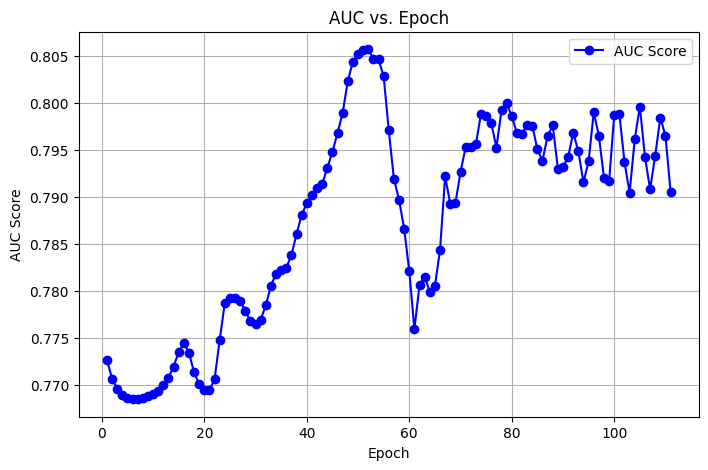

In [24]:
# Plot AUC over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AUC"]) + 1), metrics_dict["AUC"], marker='o', linestyle='-', color='b', label="AUC Score")
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()


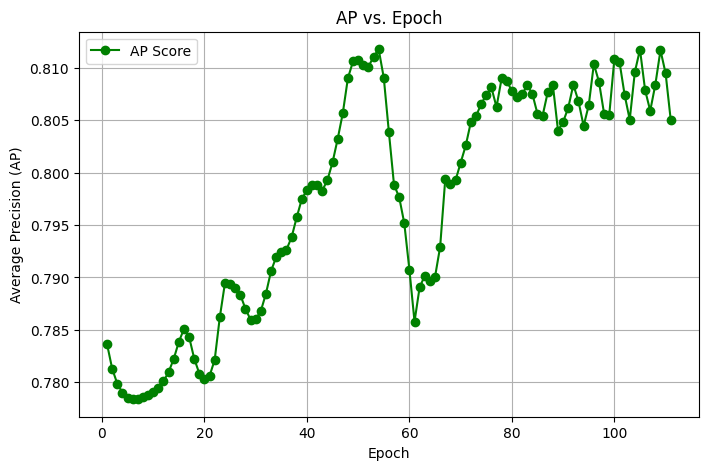

In [27]:
# Plot AP over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AP"]) + 1), metrics_dict["AP"], marker='o', linestyle='-', color='g', label="AP Score")
plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP)")
plt.title("AP vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()


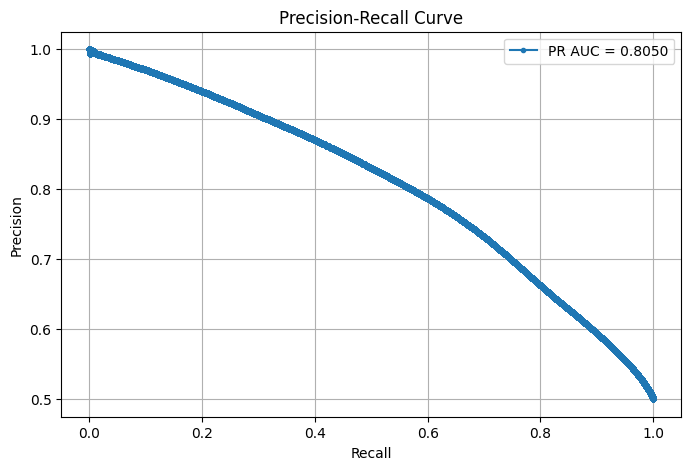

In [28]:
# Plot Precision-Recall Curve
precision = metrics_dict["Precision"][-1]  # Last epoch's precision
recall = metrics_dict["Recall"][-1]  # Last epoch's recall
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
with open("training_metrics_combined.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "AUC", "AP"])
    for i in range(len(metrics_dict["AUC"])):
        writer.writerow([i + 1, metrics_dict["AUC"][i], metrics_dict["AP"][i]])

## RNA Features

In [ ]:
valid_nodes = set(rna_pca_df['Protein'])
ppi_df_filtered = ppi_df[ppi_df['protein1'].isin(valid_nodes) & ppi_df['protein2'].isin(valid_nodes)]

filtered_nodes = pd.concat([ppi_df_filtered['protein1'], ppi_df_filtered['protein2']]).unique()
node_to_idx = {node: i for i, node in enumerate(filtered_nodes)}

ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)

scaler = StandardScaler()
ppi_df_filtered['standardized_score'] = scaler.fit_transform(ppi_df_filtered[['combined_score']])

adj_matrix = coo_matrix(
    (ppi_df_filtered['standardized_score'], (ppi_df_filtered['protein1_idx'], ppi_df_filtered['protein2_idx'])),
    shape=(len(filtered_nodes), len(filtered_nodes))

rna_pca_df['node_idx'] = rna_pca_df['Protein'].map(node_to_idx)
feature_df_filtered = rna_pca_df.dropna(subset=['node_idx']).sort_values(by='node_idx')
feature_matrix = feature_df_filtered.iloc[:, 1:-1].values  # exclude 'Protein' and 'node_idx'
feature_matrix = StandardScaler().fit_transform(feature_matrix)

assert adj_matrix.shape[0] == feature_matrix.shape[0]


edge_index, edge_attr = from_scipy_sparse_matrix(adj_matrix)
data = Data(edge_index=edge_index, edge_attr=edge_attr, x=torch.tensor(feature_matrix, dtype=torch.float))

data = train_test_split_edges(data, val_ratio=0.2, test_ratio=0.2)

data.train_pos_edge_index, _ = add_self_loops(data.train_pos_edge_index)

C:\Users\siddu\AppData\Local\Temp\ipykernel_4356\3794215482.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\AppData\Local\Temp\ipykernel_4356\3794215482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_ed

In [31]:
in_channels = data.x.shape[1]  # Number of features
out_channels = 32
model = VGAE(GCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

metrics_dict = train(model, data, optimizer)

Epoch 1/200 - Loss: 4.7675, AUC: 0.7847, AP: 0.7938
Epoch 2/200 - Loss: 4.6494, AUC: 0.7822, AP: 0.7907
Epoch 3/200 - Loss: 4.5341, AUC: 0.7799, AP: 0.7869
Epoch 4/200 - Loss: 4.4167, AUC: 0.7788, AP: 0.7850
Epoch 5/200 - Loss: 4.2515, AUC: 0.7784, AP: 0.7842
Epoch 6/200 - Loss: 4.0758, AUC: 0.7783, AP: 0.7839
Epoch 7/200 - Loss: 3.8716, AUC: 0.7783, AP: 0.7839
Epoch 8/200 - Loss: 3.6526, AUC: 0.7784, AP: 0.7840
Epoch 9/200 - Loss: 3.3837, AUC: 0.7787, AP: 0.7843
Epoch 10/200 - Loss: 3.1304, AUC: 0.7789, AP: 0.7845
Epoch 11/200 - Loss: 2.8912, AUC: 0.7791, AP: 0.7848
Epoch 12/200 - Loss: 2.6766, AUC: 0.7793, AP: 0.7850
Epoch 13/200 - Loss: 2.4803, AUC: 0.7795, AP: 0.7852
Epoch 14/200 - Loss: 2.2910, AUC: 0.7797, AP: 0.7854
Epoch 15/200 - Loss: 2.1118, AUC: 0.7799, AP: 0.7856
Epoch 16/200 - Loss: 1.9232, AUC: 0.7802, AP: 0.7859
Epoch 17/200 - Loss: 1.7523, AUC: 0.7806, AP: 0.7863
Epoch 18/200 - Loss: 1.6155, AUC: 0.7812, AP: 0.7868
Epoch 19/200 - Loss: 1.5333, AUC: 0.7819, AP: 0.7874
Ep

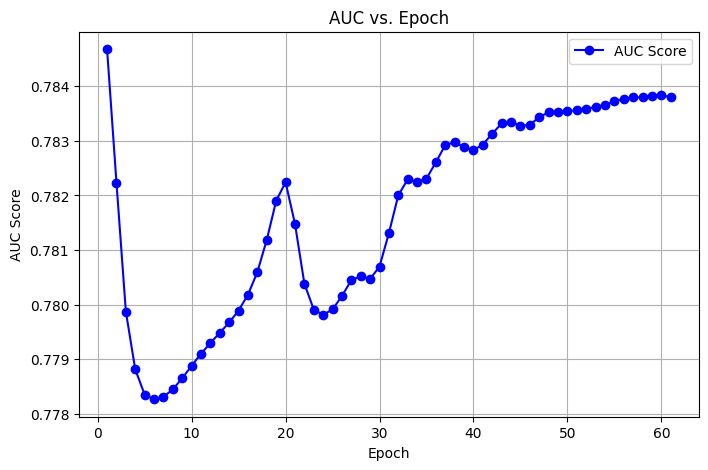

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AUC"]) + 1), metrics_dict["AUC"], marker='o', linestyle='-', color='b', label="AUC Score")
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()


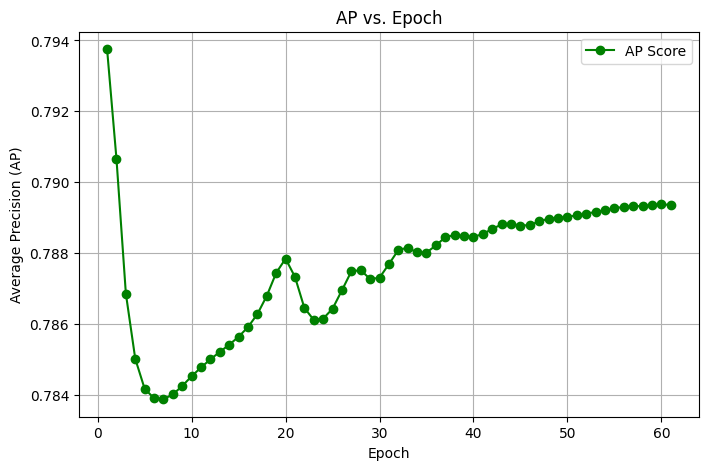

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AP"]) + 1), metrics_dict["AP"], marker='o', linestyle='-', color='g', label="AP Score")
plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP)")
plt.title("AP vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

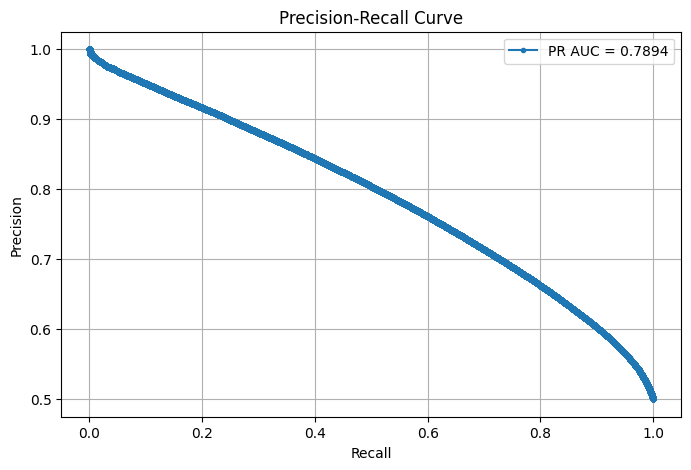

In [34]:
precision = metrics_dict["Precision"][-1]  # Last epoch's precision
recall = metrics_dict["Recall"][-1]  # Last epoch's recall
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
with open("training_metrics_rna.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "AUC", "AP"])
    for i in range(len(metrics_dict["AUC"])):
        writer.writerow([i + 1, metrics_dict["AUC"][i], metrics_dict["AP"][i]])

## Protein Expression Features

In [36]:
valid_nodes = set(pe_pca_df['Protein'])
ppi_df_filtered = ppi_df[ppi_df['protein1'].isin(valid_nodes) & ppi_df['protein2'].isin(valid_nodes)]

filtered_nodes = pd.concat([ppi_df_filtered['protein1'], ppi_df_filtered['protein2']]).unique()
node_to_idx = {node: i for i, node in enumerate(filtered_nodes)}

ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)

adj_matrix = coo_matrix(
    (ppi_df_filtered['combined_score'], (ppi_df_filtered['protein1_idx'], ppi_df_filtered['protein2_idx'])),
    shape=(len(filtered_nodes), len(filtered_nodes))
)

pe_pca_df['node_idx'] = pe_pca_df['Protein'].map(node_to_idx)
feature_df_filtered = pe_pca_df.dropna(subset=['node_idx']).sort_values(by='node_idx')
feature_matrix = feature_df_filtered.iloc[:, 1:-1].values  # exclude 'Protein' and 'node_idx'
feature_matrix = StandardScaler().fit_transform(feature_matrix)

assert adj_matrix.shape[0] == feature_matrix.shape[0]


edge_index, edge_attr = from_scipy_sparse_matrix(adj_matrix)
data = Data(edge_index=edge_index, edge_attr=edge_attr, x=torch.tensor(feature_matrix, dtype=torch.float))

data = train_test_split_edges(data, val_ratio=0.2, test_ratio=0.2)

data.train_pos_edge_index, _ = add_self_loops(data.train_pos_edge_index)

C:\Users\siddu\AppData\Local\Temp\ipykernel_4356\2604877062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\AppData\Local\Temp\ipykernel_4356\2604877062.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_ed

In [37]:
in_channels = data.x.shape[1]  # Number of features
out_channels = 32
model = VGAE(GCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

metrics_dict = train(model, data, optimizer)

Epoch 1/200 - Loss: 4.7447, AUC: 0.7696, AP: 0.7808
Epoch 2/200 - Loss: 4.5356, AUC: 0.7676, AP: 0.7787
Epoch 3/200 - Loss: 4.3282, AUC: 0.7680, AP: 0.7787
Epoch 4/200 - Loss: 4.0873, AUC: 0.7681, AP: 0.7784
Epoch 5/200 - Loss: 3.8196, AUC: 0.7682, AP: 0.7782
Epoch 6/200 - Loss: 3.5128, AUC: 0.7682, AP: 0.7780
Epoch 7/200 - Loss: 3.2344, AUC: 0.7682, AP: 0.7779
Epoch 8/200 - Loss: 2.9288, AUC: 0.7682, AP: 0.7779
Epoch 9/200 - Loss: 2.6770, AUC: 0.7682, AP: 0.7780
Epoch 10/200 - Loss: 2.4345, AUC: 0.7682, AP: 0.7780
Epoch 11/200 - Loss: 2.2042, AUC: 0.7682, AP: 0.7781
Epoch 12/200 - Loss: 1.9782, AUC: 0.7683, AP: 0.7783
Epoch 13/200 - Loss: 1.7728, AUC: 0.7688, AP: 0.7788
Epoch 14/200 - Loss: 1.6271, AUC: 0.7702, AP: 0.7801
Epoch 15/200 - Loss: 1.5243, AUC: 0.7724, AP: 0.7823
Epoch 16/200 - Loss: 1.4638, AUC: 0.7742, AP: 0.7842
Epoch 17/200 - Loss: 1.4335, AUC: 0.7744, AP: 0.7845
Epoch 18/200 - Loss: 1.4186, AUC: 0.7741, AP: 0.7842
Epoch 19/200 - Loss: 1.4083, AUC: 0.7743, AP: 0.7843
Ep

In [64]:
metrics_dict.keys()

dict_keys(['AUC', 'AP', 'Precision', 'Recall'])

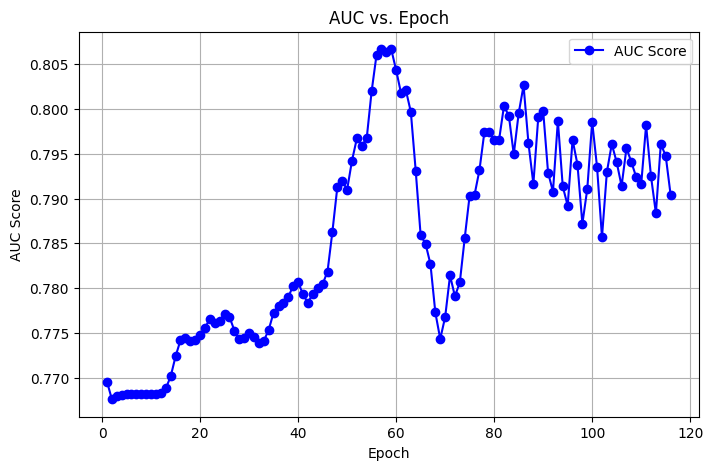

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AUC"]) + 1), metrics_dict["AUC"], marker='o', linestyle='-', color='b', label="AUC Score")
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

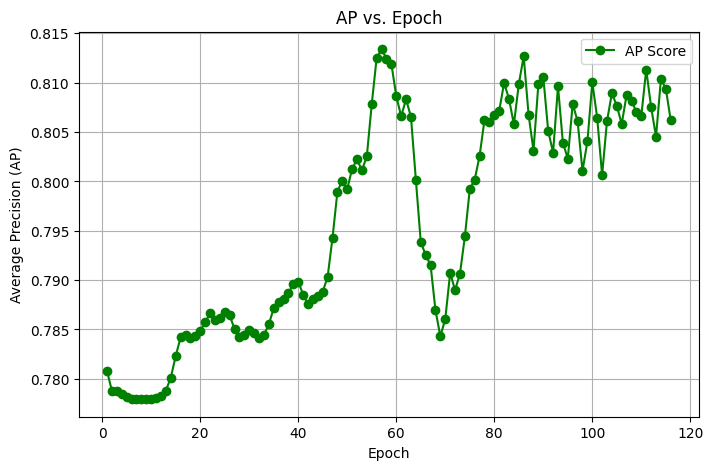

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AP"]) + 1), metrics_dict["AP"], marker='o', linestyle='-', color='g', label="AP Score")
plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP)")
plt.title("AP vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

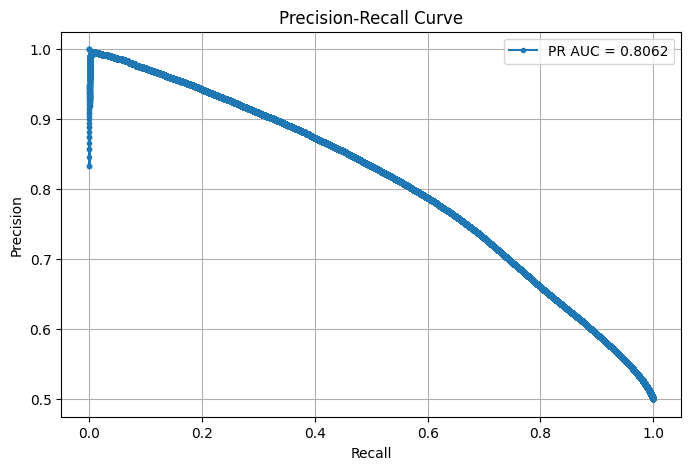

In [40]:
precision = metrics_dict["Precision"][-1]  # Last epoch's precision
recall = metrics_dict["Recall"][-1]  # Last epoch's recall
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
with open("training_metrics_pe.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "AUC", "AP"])
    for i in range(len(metrics_dict["AUC"])):
        writer.writerow([i + 1, metrics_dict["AUC"][i], metrics_dict["AP"][i]])

In [68]:
%run run_models.py --version 1


Running Version 1: Combined Features (RNA + Protein Expression)


C:\Users\siddu\capstone\DSC-180B\run_models.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\capstone\DSC-180B\run_models.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'trans

Epoch 1/200 - Loss: 4.8222, AUC: 0.7738, AP: 0.7835
Epoch 2/200 - Loss: 4.6424, AUC: 0.7681, AP: 0.7783
Epoch 3/200 - Loss: 4.4333, AUC: 0.7659, AP: 0.7768
Epoch 4/200 - Loss: 4.2429, AUC: 0.7649, AP: 0.7761
Epoch 5/200 - Loss: 4.0195, AUC: 0.7646, AP: 0.7757
Epoch 6/200 - Loss: 3.8074, AUC: 0.7644, AP: 0.7755
Epoch 7/200 - Loss: 3.5530, AUC: 0.7643, AP: 0.7754
Epoch 8/200 - Loss: 3.2802, AUC: 0.7644, AP: 0.7755
Epoch 9/200 - Loss: 3.0409, AUC: 0.7646, AP: 0.7757
Epoch 10/200 - Loss: 2.8020, AUC: 0.7648, AP: 0.7759
Epoch 11/200 - Loss: 2.5685, AUC: 0.7651, AP: 0.7762
Epoch 12/200 - Loss: 2.3426, AUC: 0.7655, AP: 0.7766
Epoch 13/200 - Loss: 2.1274, AUC: 0.7662, AP: 0.7771
Epoch 14/200 - Loss: 1.9354, AUC: 0.7672, AP: 0.7781
Epoch 15/200 - Loss: 1.7564, AUC: 0.7694, AP: 0.7801
Epoch 16/200 - Loss: 1.6273, AUC: 0.7735, AP: 0.7838
Epoch 17/200 - Loss: 1.5375, AUC: 0.7784, AP: 0.7887
Epoch 18/200 - Loss: 1.4795, AUC: 0.7806, AP: 0.7915
Epoch 19/200 - Loss: 1.4412, AUC: 0.7793, AP: 0.7905
Ep

In [69]:
%run run_models.py --version 2

Running Version 2: RNA Features Only


C:\Users\siddu\capstone\DSC-180B\run_models.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\capstone\DSC-180B\run_models.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'trans

Epoch 1/200 - Loss: 4.7138, AUC: 0.7717, AP: 0.7825
Epoch 2/200 - Loss: 4.5743, AUC: 0.7741, AP: 0.7837
Epoch 3/200 - Loss: 4.4258, AUC: 0.7751, AP: 0.7840
Epoch 4/200 - Loss: 4.2648, AUC: 0.7759, AP: 0.7843
Epoch 5/200 - Loss: 4.0833, AUC: 0.7766, AP: 0.7846
Epoch 6/200 - Loss: 3.8496, AUC: 0.7771, AP: 0.7848
Epoch 7/200 - Loss: 3.5871, AUC: 0.7776, AP: 0.7850
Epoch 8/200 - Loss: 3.3108, AUC: 0.7780, AP: 0.7853
Epoch 9/200 - Loss: 3.0427, AUC: 0.7784, AP: 0.7856
Epoch 10/200 - Loss: 2.7876, AUC: 0.7788, AP: 0.7858
Epoch 11/200 - Loss: 2.5559, AUC: 0.7791, AP: 0.7861
Epoch 12/200 - Loss: 2.3413, AUC: 0.7794, AP: 0.7863
Epoch 13/200 - Loss: 2.1223, AUC: 0.7797, AP: 0.7866
Epoch 14/200 - Loss: 1.9158, AUC: 0.7800, AP: 0.7869
Epoch 15/200 - Loss: 1.7391, AUC: 0.7805, AP: 0.7873
Epoch 16/200 - Loss: 1.5945, AUC: 0.7812, AP: 0.7878
Epoch 17/200 - Loss: 1.5043, AUC: 0.7818, AP: 0.7883
Epoch 18/200 - Loss: 1.4554, AUC: 0.7815, AP: 0.7878
Epoch 19/200 - Loss: 1.4252, AUC: 0.7802, AP: 0.7864
Ep

In [70]:
%run run_models.py --version 3

Running Version 3: Protein Expression Features Only


C:\Users\siddu\capstone\DSC-180B\run_models.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\capstone\DSC-180B\run_models.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'trans

Epoch 1/200 - Loss: 4.7209, AUC: 0.7816, AP: 0.7926
Epoch 2/200 - Loss: 4.5388, AUC: 0.7736, AP: 0.7844
Epoch 3/200 - Loss: 4.3304, AUC: 0.7698, AP: 0.7806
Epoch 4/200 - Loss: 4.0993, AUC: 0.7681, AP: 0.7787
Epoch 5/200 - Loss: 3.8401, AUC: 0.7675, AP: 0.7779
Epoch 6/200 - Loss: 3.5781, AUC: 0.7672, AP: 0.7775
Epoch 7/200 - Loss: 3.2922, AUC: 0.7671, AP: 0.7774
Epoch 8/200 - Loss: 3.0308, AUC: 0.7672, AP: 0.7774
Epoch 9/200 - Loss: 2.7859, AUC: 0.7674, AP: 0.7776
Epoch 10/200 - Loss: 2.5719, AUC: 0.7676, AP: 0.7778
Epoch 11/200 - Loss: 2.3340, AUC: 0.7680, AP: 0.7782
Epoch 12/200 - Loss: 2.1145, AUC: 0.7686, AP: 0.7787
Epoch 13/200 - Loss: 1.9208, AUC: 0.7696, AP: 0.7797
Epoch 14/200 - Loss: 1.7452, AUC: 0.7714, AP: 0.7814
Epoch 15/200 - Loss: 1.6190, AUC: 0.7744, AP: 0.7843
Epoch 16/200 - Loss: 1.5271, AUC: 0.7779, AP: 0.7878
Epoch 17/200 - Loss: 1.4749, AUC: 0.7793, AP: 0.7894
Epoch 18/200 - Loss: 1.4317, AUC: 0.7780, AP: 0.7883
Epoch 19/200 - Loss: 1.4113, AUC: 0.7772, AP: 0.7876
Ep

In [79]:
metrics_dict_combined = np.load('metrics_combined.npz', allow_pickle = True)
metrics_dict_rna = np.load('metrics_rna.npz', allow_pickle = True)
metrics_dict_pe = np.load('metrics_pe.npz', allow_pickle = True)


In [80]:
metrics_dict_combined

NpzFile 'metrics_combined.npz' with keys: auc_values, ap_values, precision_values, recall_values, allow_pickle

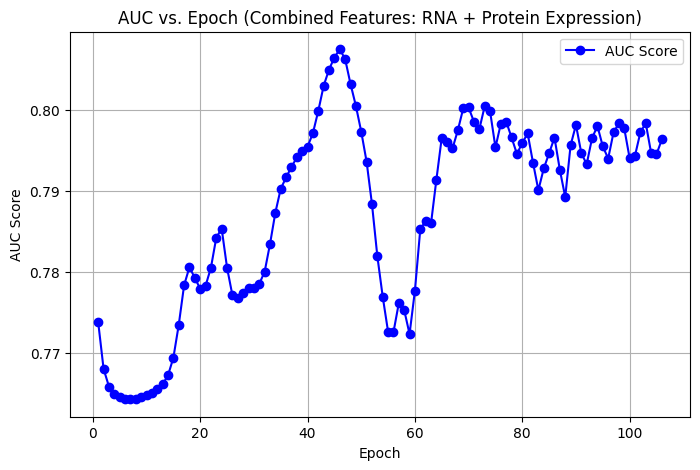

In [81]:
# Plot AUC over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict_combined["auc_values"]) + 1), metrics_dict_combined["auc_values"], marker='o', linestyle='-', color='b', label="AUC Score")
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC vs. Epoch (Combined Features: RNA + Protein Expression)")
plt.legend()
plt.grid(True)
plt.show()

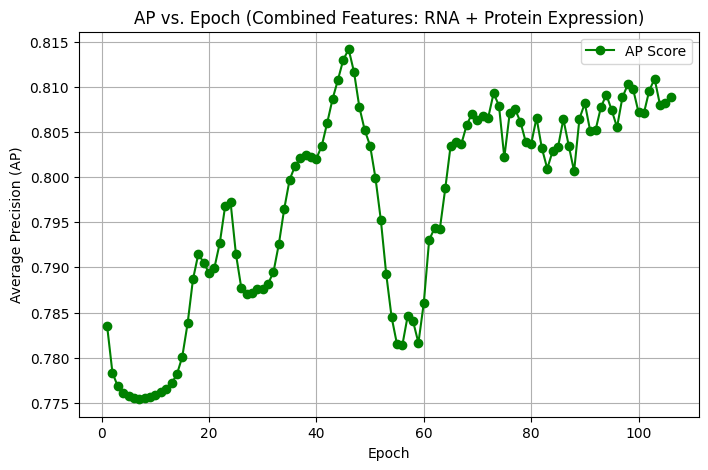

In [82]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict_combined["ap_values"]) + 1), metrics_dict_combined["ap_values"], marker='o', linestyle='-', color='g', label="AP Score")
plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP)")
plt.title("AP vs. Epoch (Combined Features: RNA + Protein Expression)")
plt.legend()
plt.grid(True)
plt.show()

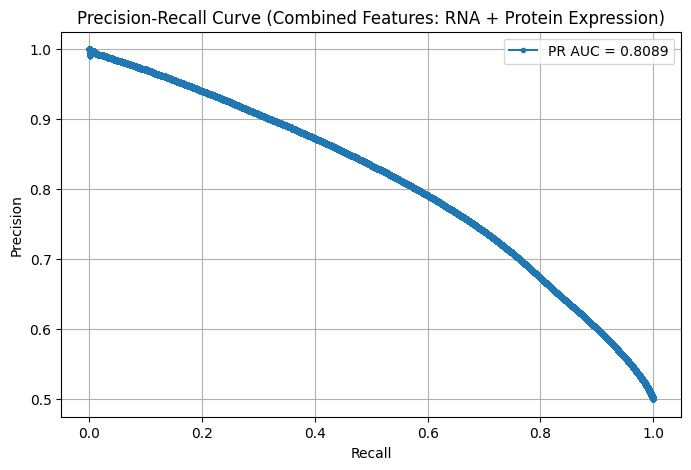

In [ ]:
precision = metrics_dict_combined["precision_values"][-1]  # Last epoch's precision
recall = metrics_dict_combined["recall_values"][-1]  # Last epoch's recall
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Combined Features: RNA + Protein Expression)")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
precision = metrics_dict_rna["precision_values"][-1]  # Last epoch's precision
recall = metrics_dict_rna["recall_values"][-1]  # Last epoch's recall
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Combined Features: RNA + Protein Expression)")
plt.legend()
plt.grid(True)
plt.show()

BadZipFile: Bad magic number for file header

In [13]:
metrics_combined

NameError: name 'metrics_combined' is not defined